# Ejercicio 3: Reducción de dimensionalidad
En este ejercicio exploraremos el uso de PCA labels t-SNE usando las librerias de scikit-learn. 
Específicamente, reduciremos la dimensionalidad de los datos para analizar cuando un tumor es benigno o maligno.

Para entender el uso de estos metodos con scikit-learn, puedes consultar la documentación oficial de scikit-learn para [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

En este ejercicio:

1. Utilizarás y explorarás un dataset de clasificación de tumores
2. Implementarás la solución analítica de PCA
3. Compararás tu solución con la implementación de scikit learn
4. Utilizarás PCA para poder visualizar tus datos de 30 variables en 2 dimensiones
5. Analizarás el uso de PCA para visualizar en 2 dimensiones, la predicción de un modelo de clasificación de 30 dimensiones


## 1. Explorando tus datos
En las siguientes celdas, cargamos el dataset que utilizamos en el ejercicio de regresión logística. Este es un conjunto de datos de clasificación, donde cada punto tiene 30 atributos o variables de entrada. Corre la siguiente celda para cargar el dataset y separar los datos en entrenamiento y prueba.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# En esta ocasión leeremos el dataset como un dataframe de pandas
dataset = load_breast_cancer(as_frame=True)
data_train, data_test, target_train, target_test = train_test_split(
    dataset['data'], 
    dataset['target'], 
    test_size=0.25,
    random_state=10
)
print(f"Datos originales de dimensionalidad {data_train.shape}")

Datos originales de dimensionalidad (426, 30)


Podemos imprimir los primeros tres renglones de nuestros datos. Esto nos sevirá para identificar como son los datos originales antes de aplicar la reducción de dimensionalidad

In [3]:
# Visualizar las primeras tres filas
print("Caracteristicas")
print(data_train.head(3))

Caracteristicas
     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
327        12.03         17.93           76.09      446.0          0.07683   
60         10.17         14.88           64.55      311.9          0.11340   
260        20.31         27.06          132.90     1288.0          0.10000   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
327           0.03892        0.001546             0.005592         0.1382   
60            0.08061        0.010840             0.012900         0.2743   
260           0.10880        0.151900             0.093330         0.1814   

     mean fractal dimension  ...  worst radius  worst texture  \
327                 0.06070  ...         13.07          22.25   
60                  0.06960  ...         11.02          17.45   
260                 0.05572  ...         24.33          39.16   

     worst perimeter  worst area  worst smoothness  worst compactness  \
327            82.74       5

In [4]:
print("Etiquetas")
print(target_train.head(3))

Etiquetas
327    1
60     1
260    0
Name: target, dtype: int32


## 2. Implementación de PCA
Para entender los conceptos vistos en clase, comenzaremos utilizando solo 2 variables de cada muestra. Es decir, aplicaremos PCA a los datos anteriores para analizar la relevancia de los atributos según las asunciones de PCA.
1. Aprenderemos como trasladar los puntos al centro para que tengan una promedio de 0
2. Obtendremos la matriz de covarianza de nuestros datos
3. Veremos los eigenvalues en la gráfica

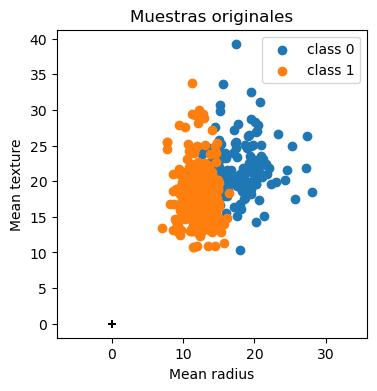

In [6]:
# Nos quedamos solo con los componentes "mean radius" y "mean texture"
X = data_train[["mean radius", "mean texture"]].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set_title("Muestras originales")
ax.axis('equal')


# En el siguiente foorloop graficamos de manera separada los puntos de distintas clases
# En este contexto, los puntos de diferentes clases se muestran en un color distinto.
for c in range(2):
    # TODO: Selecciona los valores de X que corresponden a la clase c
    # es decir, X cuando la etiqueta target_train == c
    # === Start solution ==== #
    class_datapoints = X[target_train == c]
    # === End solution ==== #
    ax.scatter(
        class_datapoints[:, 0],  # Todos los datos de clase c, columna de atributo 1
        class_datapoints[:, 1],  # Todos los datos de clase c, columna de atributo 2
        label = f"class {c}"
    )
ax.set_xlabel("Mean radius")
ax.set_ylabel("Mean texture")
# Imprimirá el origen
ax.scatter(0, 0, c="black", marker="+")
ax.legend()

### 2.1 Datos con media cero
En la imagen observamos que se encuentran desplazados del origen (representado con un '+' negro). Recuerda que PCA asume que los datos tienen una media de cero. Entonces, para poder aplicar la proyección de PCA primero necesitamos restar la media de nuestros puntos para moverlos alrededor del origen. Como nuestros datos tienen dimensionalidad, nuestra media tambien la tendrá.

$X \in \mathbb{R}^{N \times D}$

$\mu \in \mathbb{R}^{D}$

$\mu  = \left[\begin{matrix} 
                \frac{1}{N} \sum_{i=1}^{N}{X[i, 0]} \\
                \frac{1}{N} \sum_{i=1}^{N}{X[i, 1]}  \\
                \dots \\
                \frac{1}{N} \sum_{i=1}^{N}{X[i, D]}  \\
                \end{matrix} \right]$

Completa el método siguiente:

In [12]:
def get_zero_mean_data(X):
    # TODO: Restale a X el valor promedio de todos los puntos
    # Recuerda que X.shape = (N, 2) por lo que 
    # a cada punto N tienes que restarle el promedio de X[:, 0] a la primera dimensión
    # y el promedio de X[:, 1] a la segunda dimensión.
    # Consejo: Investiga el uso del atributo 'axis' para la función np.mean
    # ======== START SOLUTION =======
    X_proc = X - np.array([np.mean(X[:,0], axis = 0),np.mean(X[:,1], axis = 0)]) 
    # ========= END SOLUTION ======== 
    return X_proc

# Asegúrate de que el valor que imprima sea de (N, D) = (426, 2)
# Y que los datos de media cero esten asignados a X_proc
X = data_train[["mean radius", "mean texture"]].to_numpy()
X_proc = get_zero_mean_data(X)
print("media shape", X_proc.shape)

media shape (426, 2)


Una vez calculado lo anterior, podemos graficar nuestros nuevos datos con media cero. Corre la siguiente celda para visualizar tus nuevos datos

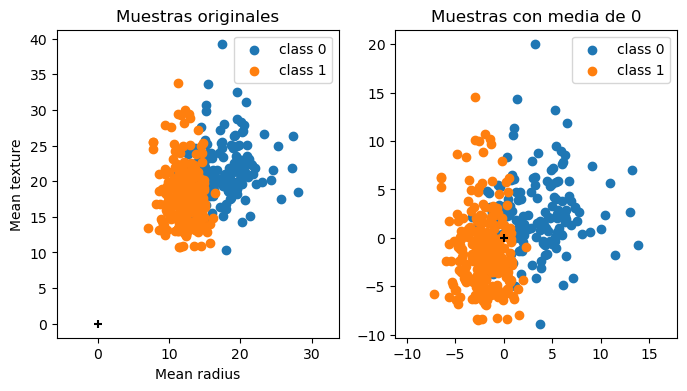

In [20]:
# ============= Muestras originales ==============
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.set_title("Muestras originales")
ax1.axis('equal')
for c in range(2):
    class_datapoints = X[target_train == c]
    ax1.scatter(
        class_datapoints[:, 0], 
        class_datapoints[:, 1], 
        label = f"class {c}"
    )
ax1.set_xlabel("Mean radius")
ax1.set_ylabel("Mean texture")
ax1.scatter(0, 0, c="black", marker="+")
ax1.legend()


# Nuevos datos
ax2.set_title("Muestras con media de 0")
ax2.axis('equal')
ax2.scatter(0, 0, c="black", marker="+")
# Grafica los datos y veras la figura desplazada hacia el origen
for c in range(2):
    ax2.scatter(
        X_proc[:, 0][target_train == c], 
        X_proc[:, 1][target_train == c], 
        label = f"class {c}"
    )
ax2.legend()
# Imprimirá el origen
ax2.scatter(0, 0, c="black", marker="+")
ax2.legend()

###  2.2-3 Direcciones de proyección y la matríz de covarianza
En clase vimos que la solución de PCA está dada por los vectores propios de la matriz de covarianza. Ya que estós determinan la mejor dirección de proyección según las asunciones del método.

En la siguiente celda, termina el método para calcular los valores y vectores propios de la matríz de covarianza.
Recuerda que los vectores propios $v \in \mathbb{R}^{D \times D}$ donde $v[:, i] \forall i = {0,1, \dots, D}$ corresponde al vector (columna) propio $v_i$. Asegúrate de que tu método regrese los vectores de dimensionalidad correcta

In [17]:
def get_sorted_eigvectors(X):
    '''
        Calcula los vectores y valores propios de una matriz con media cero X
        args:
            - X  (np.ndarray): Matriz de datos con media cero de dimensionalidad N x D
        returns:
            - eigenvectors (np.ndarray): vectores propios de la matriz de cov. de X.  Dimensionalidad de D x D
            - eigenvalues (np.ndarray, dtype=float): valores propios de la matriz de cov. de X en el mismo orden que los vectores propios
    '''
    # Estimaremos una matriz de covarianza para los puntos con
    # promedio de 0 y desviacion estandar de 1
    sample_cov = np.cov(X, rowvar=0)
    # TODO: Calcula los valores y vectores propios de la matriz de covarianza
    # Utiliza np.linalg.eig()
    # =========== Start solution ==============
    eigenvalues, eigenvectors = np.linalg.eig(sample_cov)
    # =========== End solution ================

    # La sig. linea regresa los índices de los eigenvalues en orden del mayor al menor eigenvalue
    # [::-1] invierte el orden (osea si argsort regresa del menor al mayor ...
    # ... usar [::-1] hace que regrese de mayor a menor)
    idx_ordered =  np.argsort(eigenvalues)[::-1]

    # TODO: Ordena los eigenvalues y eigenvectors de mayor a menor eigenvalue
    # Utiliza los índices previamente calculados
    # regresa los eigenvectors y eigenvalues en el orden indicado
    # =========== Start solution ==============
    eigenvalues = eigenvalues[idx_ordered]
    eigenvectors = eigenvectors[:, idx_ordered]
    # =========== End solution ================
    return eigenvectors, eigenvalues

# Nos quedamos solo con los componentes "mean radius" y "mean texture"
X = data_train[["mean radius", "mean texture"]].to_numpy()
X_proc = get_zero_mean_data(X)
# Tomar los eigenvectors y eigenvalues de la matriz de covarianza
eigvecs, eigvals = get_sorted_eigvectors(X)
assert eigvecs.shape == (2,2), f"eigvecs.shape de dimensionalidad {eigvecs.shape} debería ser (2x2)"
print("Vectores propios de dimensionalidad:", eigvecs.shape)

# TODO: Proyecta los datos de media cero a los primeros dos vectores propios
# y asigna el resultado a X_proj
# =========== Start solution ==============
X_proj = X_proc @ eigvecs[:, :2]
# =========== End solution ================

assert X_proj.shape == (len(X),2), f"X_proj.shape de dimensionalidad {X_proj.shape} debería ser ({len(X)}x2)"
print("Proyección de dimensionalidad:", X_proj.shape)


Vectores propios de dimensionalidad: (2, 2)
Proyección de dimensionalidad: (426, 2)


Corre la siguiente celda para visualizar los vectores propios sobrepuestos a tus datos originales y a los datos proyectados a la base dada por los mismos.

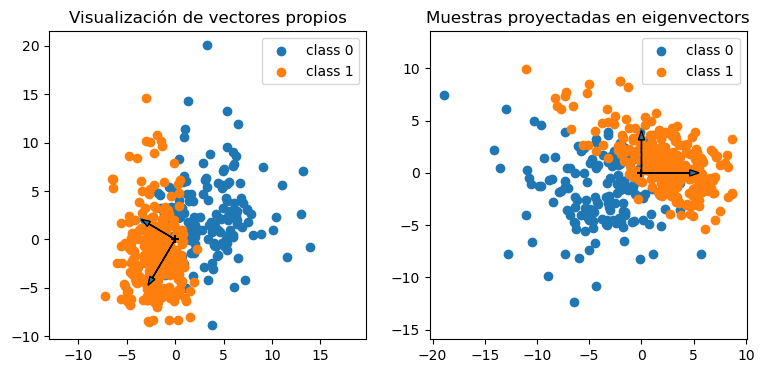

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
# ============= Datos con media cero ==============
ax1.set_title("Visualización de vectores propios")
ax1.axis('equal')
# Graficamos los datos de nuevp
for c in range(2):
    ax1.scatter(
        X_proc[:, 0][target_train == c], 
        X_proc[:, 1][target_train == c], 
        label = f"class {c}"
    )
# Graficamos los vectores sobrepuestos a los datos en el ax anterior
for idx_col in range(eigvals.shape[0]):
    norm_eig = np.sqrt(eigvals[idx_col])
    start_point = [0, 0]
    end_point = eigvecs[:, idx_col] * norm_eig
    ax1.arrow(*start_point, *end_point, width = 0.03, head_width = 0.6)
ax1.legend()
ax1.scatter(0, 0, c="black", marker="+")

# ============= Muestras proyectadas ==============
ax2.set_title("Muestras proyectadas en eigenvectors")
ax2.axis('equal')
ax2.scatter(0, 0, c="black", marker="+")
for c in range(2):
    ax2.scatter(
        X_proj[:, 0][target_train == c], 
        X_proj[:, 1][target_train == c], 
        label = f"class {c}"
    )
# Graficamos los vectores sobrepuestos a los datos en el ax anterior
end_pts = np.array([[1,0],[0,1]])
for idx_col in range(eigvals.shape[0]):
    norm_eig = np.sqrt(eigvals[idx_col])
    start_point = [0, 0]
    end_point = end_pts[idx_col] * norm_eig
    ax2.arrow(*start_point, *end_point, width = 0.03, head_width = 0.6)
ax2.scatter(0, 0, c="black", marker="+")
ax2.legend()

## 3. Comparación con la librería de scikit learn
En la siguiente sección compararemos tu implementación de PCA con la de scikit learn. Primero analizaremos proyectar datos de dos dimensiones en 1, y después proyectaremos nuestros datos de 10 variables a 2 para poder visualizarlos.

### Usando PCA para reducir 2 dimensiones a 1
En las siguientes celdas filtraremos los datos para inicialmente trabajar con 2 dimensiones. Después utilizaremos los métodos que anteriormente definiste (`get_zero_mean_data` & `get_sorted_eigenvectors`) para comparar tu implementación de PCA con la de scikit-learn.

La siguiente celda define un método que normaliza los datos (resta la media y escala los datos) para poder proyectarlos a los eigenvectors calculados por `get_sorted_eigenvectors`

In [ ]:
def norm_data(X):
    mean = X.mean(0)
    std = X.std(0)
    X_proc = (X - mean)
    new_data = X_proc / std
    return new_data

Corre la siguiente celda, analiza la imagen y responde:

\# TODO:
Para la tarea de clasificación ¿Cual vector propio crees que te permita separar mejor los datos al proyectarse en el? Explica tu intuición.

In [ ]:
feat1, feat2 = "mean radius", "mean compactness"
labels = target_train
X = data_train[[feat1, feat2]].to_numpy()
X = norm_data(X)
print(X.shape)

eigvecs, eigvals = get_sorted_eigvectors(X)
print(eigvecs.shape)

# ========== Graficas ===============
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# Espacio original
for c in range(2):
    ax.scatter(
        X[:, 0][labels == c], 
        X[:, 1][labels == c], 
        label = f"class {c}"
    )

# Graficamos los vectores sobrepuestos a los datos en el ax anterior
for idx_col in range(eigvals.shape[0]):
    norm_eig = np.sqrt(eigvals[idx_col])
    start_point = np.mean(X, axis=0)
    end_point = eigvecs[:, idx_col] * norm_eig
    ax.arrow(*start_point, *end_point, width = 0.03, head_width = 0.3)
ax.axis('equal')
ax.set_title('Datos con media cero')
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)

#### Proyección a una dimensión
Ahora que has visto tus datos considerando solo dos variables distintas. Vamos a proyectar los datos a ambos vectores propios para visualizar como se verían en 1 sola dimensión. 

Esto nos permite para analizar que proyección permite mejor separabilidad de los datos para la tarea de clasificación. Recuerda que los vectores propios $v \in \mathbb{R}^{D \times D}$ donde $v[:, i] \forall i = \{0,1, \dots, D\}$ corresponde al vector (columna) propio $v_i$.

\#TODO:

Corre las siguientes dos celdas y responde:

En este caso, ¿se cumple la asunción de PCA de que el primer componente principal mantiene la información más importante?

In [ ]:
normed_data_train = norm_data(data_train)
# Datos normalizados (media cero y misma escala)
X = normed_data_train[[feat1, feat2]].to_numpy()
eigvecs, eigvals = get_sorted_eigvectors(X)

# ========= TU Solución ============#
# TODO: Proyecta los datos al primer componente principal eigvecs[:,0]
# =========== Start solution ==============
X_proj1 = ...

# TODO: Proyecta los datos al segundo componente principal eigvecs[:,1]
X_proj2 = ...
# =========== End solution ================= 


# ========= Solución de scikit learn ============#
from sklearn.decomposition import PCA
# TODO: Utiliza la libreria de scikit-learn para reducir X a 1 dimensión
# Invesitga PCA en scikit learn. Asigna el resultado a reduced_x
# =========== Start solution ==============
reduced_x = ...
# =========== End solution ================= 

In [ ]:
# Recuerda siempre correr la celda anterior antes de correr esta
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
# Espacio original
for c in range(2):
    ax1.scatter(
        X[:, 0][labels == c], 
        X[:, 1][labels == c], 
        label = f"class {c}"
    )

# Graficamos los vectores sobrepuestos a los datos en el ax anterior
for idx_col in range(eigvals.shape[0]):
    norm_eig = np.sqrt(eigvals[idx_col])
    start_point = np.mean(X, axis=0)
    end_point = eigvecs[:, idx_col] * norm_eig
    ax1.arrow(*start_point, *end_point, width = 0.03, head_width = 0.3)
ax1.axis('equal')
ax1.set_title('Datos con media cero')
ax1.set_xlabel(feat1)
ax1.set_ylabel(feat2)

for c in range(2):
    class_data = X_proj1[labels == c]
    N_samples = len(class_data)
    ax2.scatter(
        class_data, 
        np.zeros(N_samples), 
        label = f"class {c}"
    )
ax2.set_title('Proyección al 1er CP')

for c in range(2):
    class_data = X_proj2[labels == c]
    N_samples = len(class_data)
    ax3.scatter(
        class_data, 
        np.zeros(N_samples), 
        label = f"class {c}"
    )
ax3.set_title('Proyección al 2do CP')


## Solución de scikit-learn (1 dim)
# plot reduced data
for c in range(2):
    class_idx = np.where(target_train == c)[0]
    N_samples = len(class_idx)
    ax4.scatter(
        reduced_x[class_idx][:,0],
        np.zeros(N_samples),
        label = f"class {c}"
    )
ax4.set_title('Solución de scikit-learn (1 dimensión)')

plt.show()

Ahora que has visto como proyectar tus datos a distintos componentes principales. Implementa el método de mi_PCA usando las funciones anteriormente deifindas. Para ello proyecta los datos a los primeros `n_components` vectores propios y regresa el resultado de la proyección

In [ ]:
def mi_PCA(data, n_components=1):
    zero_mean = get_zero_mean_data(data)
    eigvecs, eigvals = get_sorted_eigvectors(zero_mean)
    # TODO: proyecta los datos a los primeros n_components vectores propios y regresa el resultado
    # =========== Start solution ==============
    x_proj = ...
    # =========== End solution ================= 
    return x_proj

# Prueba tu solución
X = data_train.to_numpy()
for output_dims in range(1,4):
    reduced_x_mine = mi_PCA(X, output_dims)
    assert reduced_x_mine.shape == (len(X),output_dims), f"X_proj.shape de dimensionalidad {reduced_x_mine.shape} debería ser ({len(X)}x{output_dims})"
    print(f"Mi solución: Datos originales {X.shape}, Datos proyectados para {output_dims} dims: {reduced_x_mine.shape}")

## 4. Usando PCA para reducir 30 dimensiones a 2

En la sección anterior, filtramos nuestros datos originales para quedarnos solo con dos variables. En esta sección consideramos los datos en su estado original, es decir con las 30 variables de entrada. Por su puesto, es imposible visualizarlso de esta forma, por lo tanto usaremos PCA para reducir la dimensionalidad de los datos originales a solo 2 dimensiones para poder visualizarlos.

Usando PCA podemos transformar un dataset de $D$ variables proyectándolos a los $K$ vectores propios con los mayores valores propios perdiendo la menor información posible. De esta manera PCA mapea.

$X_{orig} \in \mathbb{R}^{N \times D} \mapsto X_{reduced} \in \mathbb{R}^{N \times 2}$

Podemos resolver problema utilizando tu implementación y las librerias de scikit-learn. Ambas deberían generar una distribución de datos muy similar.

In [ ]:
X = data_train.to_numpy()
output_dims = 2
# ============= TU solución ===============
# TODO: Reduce los datos en X a output_dims usando tu implementación de mi_PCA(data, n_components=...)
reduced_x_mine = ...
# =========== End solution ================= 
print(f"Mi solución: Datos originales {X.shape}, Datos proyectados {reduced_x_mine.shape}")

# ============= Solución  de scikit-learn ===============
from sklearn.decomposition import PCA
# TODO: Reduce los datos en X a output_dims usando la implementación de sciki-learn
reduced_x_lib = ...
# =========== End solution ================= 
print(f"Scikit learn: Datos originales {X.shape}, Datos proyectados {reduced_x_lib.shape}")

In [ ]:
# Graficamos los datos de nuestra solución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for c in range(2):
    ax1.scatter(
        reduced_x_mine[:, 0][target_train == c], 
        reduced_x_mine[:, 1][target_train == c], 
        label = f"class {c}"
    )
ax1.set_title("Mi solución")
ax1.legend()

# plot reduced data
for c in range(2):
    class_idx = np.where(target_train == c)
    ax2.scatter(
        reduced_x_lib[class_idx, 0],
        reduced_x_lib[class_idx, 1],
        label = f"class {c}"
    )
ax2.set_title("La solución de scikit-learn")
ax2.legend()

### Otros métodos de reducción de dimensionalidad

Como PCA, existen otras alternativas para reducir la dimensionalidad de los datos. Una muy popular es el algoritmo de TSNE.
Mientras que ambos métodos sirven el mismo propósito, se utilizan en situaciones distintas. PCA normalmente se utiliza cuando queremos reducir dimensionalidades muy altas, a unas pequeñas por ejemplo reducir de 100 a 50 o 10 dimensiones. 

Por otro lado TSNE funciona bien cuando tenemos una dimensionalidad relativamente baja (entre 20 y 5 por ejemplo) y queremos reducirla a una más pequeña para poder visualizar nuestros datos (por ejemplo 3,2 o 1).

TSNE tiene un hiperparámetro adicional a la cantidad de componentes de salida, llamado "perplexidad". Si te interesa conocer más sobre TSNE puedes revisar la [documentación de sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Corre la siguiente celda para visualizar como TSNE reduce las 30 dimensiones de nuestros datos originales a 2

In [ ]:
from sklearn.manifold import TSNE
# Convertimos nuestros datos de entrenamiento a un arreglo de numpy

# Nuestra matriz de datos tiene 712 datos con 8 variables.
X = data_train.to_numpy()
tsne = TSNE(n_components=2, perplexity=50)
reduced_x = tsne.fit_transform(X)
print(reduced_x.shape)

# plot reduced data
fig, ax = plt.subplots(figsize=(8, 5))
for c in range(2):
    class_idx = np.where(target_train == c)
    ax.scatter(
        reduced_x[class_idx, 0],
        reduced_x[class_idx,1], 
        label = f"class {c}"
    )
ax.legend()

## 5. Reducción de dimensionalidad aplicado a tareas adicionales
PCA normalmente se utiliza cuando queremos visualizar lo que ha aprendido nuestro algoritmo para entradas de alta dimensionalidad. Tenemos dos opciones

1. Podemos entrenar con el dataset reducido un algoritmo de clasificación, como regresión logística.
2. Podemos entrenar regresión logística en alta dimensionalidad y usar PCA para reducir la dimensionalidad y visualizar el resultado.

Corre las siguientes celdas para observar como funciona (:

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Podemos utilizar diferentes algoritmos de reducción de datos como TSNE
# Aquí definimos un método para seleccionar que algoritmo usar
# para reducir la dimensionalidad de nuestros datos
def reduce_data(data, method='PCA', output_dims=2):
    if method == 'TSNE':
        tsne = TSNE(n_components=output_dims, perplexity=50)
        reduced_x = tsne.fit_transform(data)
    elif method == 'PCA':
        pca = PCA(n_components=output_dims)
        reduced_x = pca.fit_transform(data)
    else:
        print("Método no disponible %s" %method)
        reduced_x = data
    return reduced_x

### 5.1. Entrenar en datos reducidos

In [ ]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

# Train set
X = data_train.to_numpy()
y = target_train.to_numpy()

# Test set
X_test = data_test.to_numpy()
y_test = target_test.to_numpy()

# Metodos
methods = ['PCA', 'TSNE']
fig1, axes_pred = plt.subplots(1, len(methods), figsize=(10, 3))
fig2, axes_correct = plt.subplots(1, len(methods), figsize=(10, 3))

for method, ax_pred, ax_correct in zip(methods, axes_pred, axes_correct):
    reduced_x = reduce_data(X, method=method, output_dims=2)
    print(f"Reducción de {X.shape} a {reduced_x.shape}")
    clf = LogisticRegression(random_state=0).fit(reduced_x, y)
    pred = clf.predict(reduced_x)
    error = np.sum(np.abs(y - pred)) / X.shape[0]
    print(f"Reg. logística train, reducción {method}, error de entrenamiento: {error}")

    reduced_x_test = reduce_data(X_test, method=method, output_dims=2)
    pred = clf.predict(reduced_x_test)
    error = np.mean(np.abs(y_test - pred))
    print(f"Reg. logística test {reduced_x_test.shape}, reducción {method}, error de prueba: {error}")

    # Graficar predicciones del método
    for c in range(2):
        class_idx = np.where(pred == c)
        ax_pred.scatter(
            reduced_x_test[class_idx, 0],
            reduced_x_test[class_idx,1], 
            label = f"class {c}"
        )
    
    # Graficar en que puntos predijo correctamente la clase
    puntos = {"correcto":{
                    "indices": np.where(pred == y_test),
                    "color": 'green'},
             "incorrecto":{
                    "indices": np.where(pred != y_test),
                    "color": 'red'}
             }
    for label, info in puntos.items():
        ax_correct.scatter(
            reduced_x_test[info["indices"], 0],
            reduced_x_test[info["indices"],1], 
            label = label,
            color = info["color"]
        )

    # Visualización de clases
    fig1.suptitle("Clases")
    ax_pred.set_title(f"Visualización con {method}")
    ax_pred.legend()

    # Visualización de correcto vs incorrecto
    fig2.suptitle("Clases clasificadas correcta/incorrectamente")
    ax_correct.set_title(f"Visualización con {method}")
    ax_correct.legend()
plt.show()

### 5.2. Entrenar en alta dimensionalidad y reducir dimensionalidad para visualización

In [ ]:
from sklearn.linear_model import LogisticRegression
X = data_train.to_numpy()
y = target_train.to_numpy()

# Entrenamos un clasificador
clf = LogisticRegression(random_state=0).fit(X, y)
pred = clf.predict(X)
error = np.sum(np.abs(y - pred)) / X.shape[0]
print(f"Error de entrenamiento:", error)

# Nuestros datos son de dimensionalidad 30 osea no podemos visualizar la predicción
# Aplicamos reducción de dimensonalidad para visualizar la predicción de nuestro modelo
# En el set de prueba
X_test = data_test.to_numpy()
y_test = target_test.to_numpy()
pred = clf.predict(X_test)
error = np.mean(np.abs(y_test - pred))
print(f"Reg. logística test {X_test.shape}, error de prueba: {error}")

# Aplicamos reducción de dimensonalidad para visualizar la predicción de nuestro modelo
methods = ['PCA', 'TSNE']
fig1, axes_pred = plt.subplots(1, len(methods), figsize=(10, 3))
fig2, axes_correct = plt.subplots(1, len(methods), figsize=(10, 3))
for method, ax_pred, ax_correct in zip(methods, axes_pred, axes_correct):
    reduced_x_test = reduce_data(X_test, method=method, output_dims=2)
    # Graficar predicciones del método
    for c in range(2):
        class_idx = np.where(pred == c)
        ax_pred.scatter(
            reduced_x_test[class_idx, 0],
            reduced_x_test[class_idx,1], 
            label = f"class {c}"
        )
    
    # Graficar en que puntos predijo correctamente la clase
    puntos = {"correcto":{
                    "indices": np.where(pred == y_test),
                    "color": 'green'},
             "incorrecto":{
                    "indices": np.where(pred != y_test),
                    "color": 'red'}
             }
    for label, info in puntos.items():
        ax_correct.scatter(
            reduced_x_test[info["indices"], 0],
            reduced_x_test[info["indices"],1], 
            label = label,
            color = info["color"]
        )

    # Visualización de clases
    fig1.suptitle("Clases")
    ax_pred.set_title(f"Visualización con {method}")
    ax_pred.legend()

    # Visualización de correcto vs incorrecto
    fig2.suptitle("Clases clasificadas correcta/incorrectamente")
    ax_correct.set_title(f"Visualización con {method}")
    ax_correct.legend()
plt.show()

### TODO: En base a lo anterior
- ¿Qué puedes concluir?
- ¿De que nos sirve reducir la dimensionalidad de los datos?
- Para el ejemplo anterior, ¿Qué funciona mejor, entrenar en datos reducidos o en alta dimensionalidad?